# Alcance

El presente documento tendrá como objetivo la elaboración de un modelo de Machine Learning que permita la valuación de una propiedad utilizando variables que reduzcan la injerencia de la subjetividad del tasador.

Para lograr esto, en primer lugar, en el apartado Introducción se enumerarán los distintos factores que influyen sobre el precio de las distintas propiedades. Posteriormente, en la sección Análisis Exploratorio se investigarán las características del dataset provisto, para, en último lugar, determinar el mejor modelo descriptivo

# 1. Pensando como un data scientist

Para abordar el problema de manera integral, en primer lugar detallaré los distintos factores que pueden influir sobre el precio de una propiedad. Estos son:

**A nivel macroentorno:**
- Oferta de hogares en la ciudad (Cantidad de meses necesarios para ubicar la totalidad de viviendas en venta dado el ritmo actual)
- Situación de empleos (crecimiento, estabilidad)
- Tasas de interés
- Valor del m2 relativo al salario medio
- Valor del dólar
- Inflación
- Regulaciones de gobierno

**A nivel microentorno:**
- Ubicación de conglomerados de empresas
- Cercanía a shoppings, universidades, estaciones de subte, supermercados
- Barrio

**Propiedades de la construcción:**
- Presencia de amenities
- Edad del edificio
- Servicios disponibles (por ejemplo gas, o instalación de fibra óptica)
- Metros cuadrados
- Cantidad de habitaciones
- Tipo de propiedad
- Número de piso
- Frente o contrafrente
- Presencia o no de balcón en caso de ser un departamento

Dado que sólamente cuento con datos propios de las distintas publicaciones, sólo tomaré en cuenta los factores de la última categoría para el presente análisis, aunque adicionar cuestiones relativas al macro y microentorno podría incrementar la precisión del modelo.

# 2. Análisis exploratorio de datos

## Alcance

La presente sección tendrá como objetivo determinar las características del dataset provisto, realizar una limpieza de los outliers y determinar las distintas variables a utilizar en el modelo de regresión

## Desarrollo

En primer lugar, importamos las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

A continuación, cargamos el dataset provisto. Podemos ver que existen 146.660 propiedades registradas, con 19 atributos por cada una

In [2]:
properati = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
print(properati.shape)
properati.head(5)

(146660, 19)


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


Se puede observar, también, que existen 67.982 valores faltantes, los cuales se detallan a continuación:

In [3]:
faltantes = pd.isnull(properati).values.sum()
print('Existen '+str(faltantes)+' valores faltantes en el dataset provisto'+'\n')
print(properati.isnull().sum())

Existen 67982 valores faltantes en el dataset provisto

start_date             0
end_date               0
created_on             0
lat                 9925
lon                 9959
l1                     0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64


Se puede observar que existe una gran cantidad (alrededor de 15%) de propiedades que no cuentan con su superficie total y cubierta cargadas entre sus atributos. También vemos que en algunos casos no se cargan las coordenadas de las mismas ni los baños ya que no son atributos obligatorios a la hora de generar una publicación.

Existen 10 tipos de propiedades en el dataset:

In [4]:
print('Existen {} tipos de propiedades en el dataset, a saber: '.format(len(properati.property_type.unique()))+str(properati.property_type.unique()))

Existen 10 tipos de propiedades en el dataset, a saber: ['Departamento' 'PH' 'Casa' 'Lote' 'Casa de campo' 'Oficina' 'Otro'
 'Local comercial' 'Cochera' 'Depósito']


El 98% de las propiedades son departamento, casa o PH. Podemos ver esto en el siguiente gráfico de barras:

Las propiedades del tipo departamento, casa o PH abarcan el 98% del total


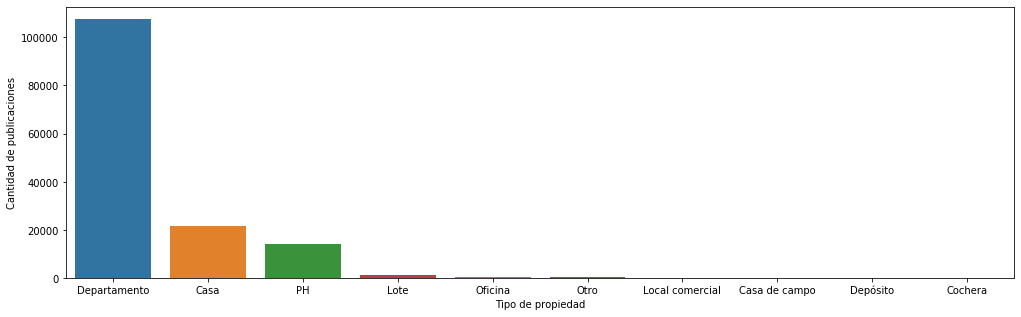

In [5]:
plt.figure(figsize=(17,5))
sns.countplot(x='property_type',data=properati,order=properati['property_type'].value_counts().sort_values(ascending=False).index)
plt.xlabel('Tipo de propiedad')
plt.ylabel('Cantidad de publicaciones')
totalPropiedades = properati.property_type.count()
propiedadesPrincipales = properati[properati.property_type.isin(['Departamento','PH','Casa'])].property_type.count()
print('Las propiedades del tipo departamento, casa o PH abarcan el '+"{:.0%}". format(propiedadesPrincipales/totalPropiedades)+' del total')

Las publicaciones no presentan una distribución geográfica uniforme.

La gran mayoría (63.10%) de las propiedades fueron publicadas en **Capital Federal**, mientras que los barrios más prevalentes son **Palermo, Tigre, Almagro, Belgrano, Caballito, Villa Crespo, Recoleta, La Plata, La Matanza y Pilar**, los cuales acaparan el 45,78% del total de publicaciones

Se publicaron en Capital Federal el 63.10% de las propiedades


Los 10 primeros barrios son 
Palermo         13073
Tigre            8718
Almagro          7527
Belgrano         6935
Caballito        6650
Villa Crespo     6494
Recoleta         5917
La Plata         4354
La Matanza       3757
Pilar            3709
Name: l3, dtype: int64

Estos acaparan el 45.78% de las propiedades publicadas


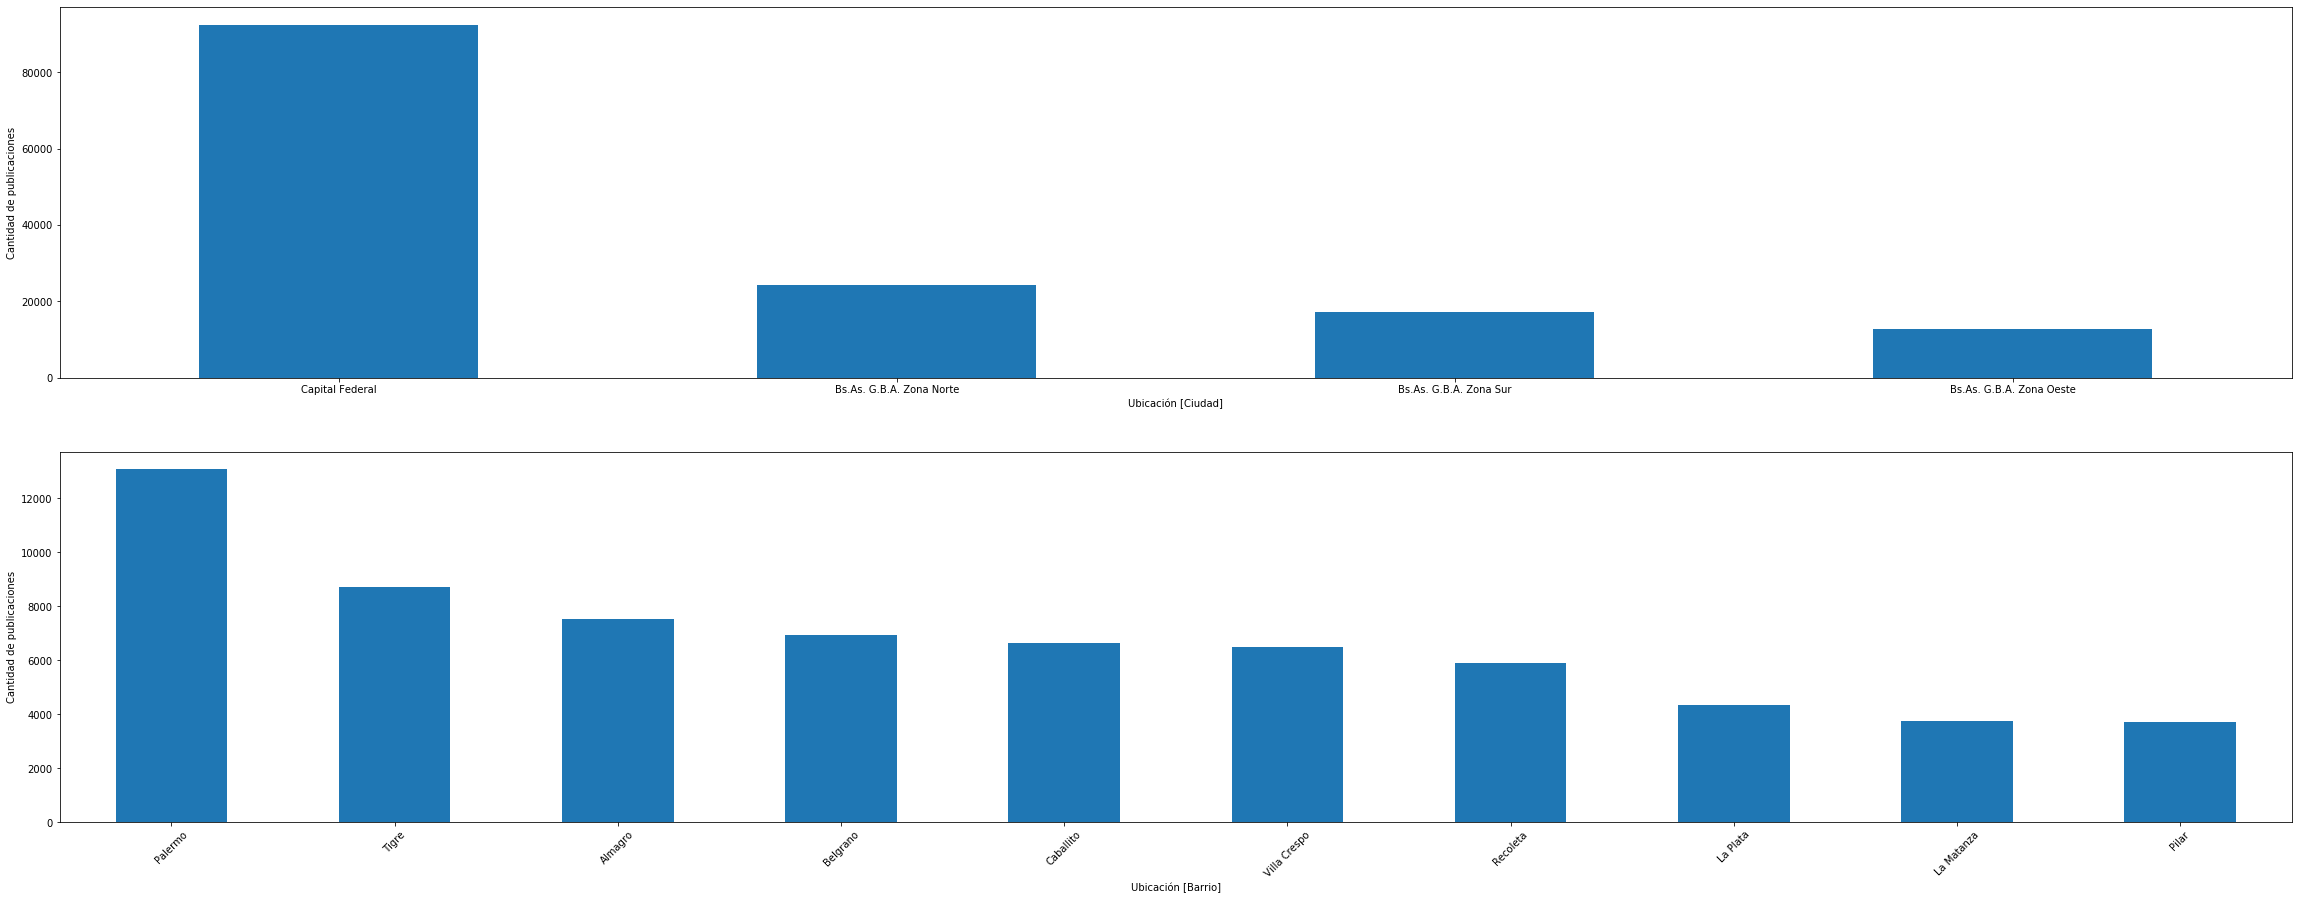

In [6]:
topBarrios = properati[properati.l3.isin(properati.l3.value_counts().head(10).index)]
plt.figure(figsize=(40,15))

plt.subplot(2,1,1)
properati["l2"].value_counts().plot.bar()
matplotlib.pyplot.xticks(rotation=0)
plt.xlabel('Ubicación [Ciudad]')
plt.ylabel('Cantidad de publicaciones')

plt.subplot(2,1,2)
topBarrios['l3'].value_counts().plot.bar()
matplotlib.pyplot.xticks(rotation=45)
plt.xlabel('Ubicación [Barrio]')
plt.ylabel('Cantidad de publicaciones')

top10Barrios = properati["l3"].value_counts().head(10)
numPropiedades = properati.shape[0]
print("Se publicaron en Capital Federal el "+"{:.2%}".format(properati["l2"].value_counts().head(1).sum()/numPropiedades)+" de las propiedades\n\n")
print("Los 10 primeros barrios son \n"+str(top10Barrios)+"\n")
print("Estos acaparan el "+ "{:.2%} ".format(top10Barrios.sum()/numPropiedades)+"de las propiedades publicadas")

A fin de simplificar el análisis, trabajaremos con las propiedades que se encuentren en **Capital Federal**, que sean del tipo **PH**, **Departamento** o **Casa**. Estas son, en total, 91.485

In [7]:
properatiFiltrado = properati[properati.property_type.isin(['PH','Departamento','Casa'])&
                    properati.l2.isin(['Capital Federal'])]
properatiFiltrado.shape

(91485, 19)

Para simplificar el dataset y trabajar sobre los atributos más relevantes del mismo, quitaremos los siguientes:
- **lat** (latitud)
- **lon** (longitud)
- **start_date** (fecha de inicio de publicación)
- **end_date** (fecha de baja de publicación)
- **created_on** (fecha de creación de la publicación)
- **l1** (país)
- **l2** (ciudad)
- **l3** (barrio)
- **currency** (moneda)
- **title** (título de publicación)
- **description** (descripción)
- **operation_type** (tipo de operación)

In [8]:
properatidf = properatiFiltrado.drop(columns=['lat','lon','start_date','end_date','created_on','l1','l2','l3','currency','title','description','operation_type'])
properatidf

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,2.0,1.0,1.0,85.0,50.0,295000.0,PH
5,2.0,1.0,1.0,56.0,56.0,150000.0,PH
...,...,...,...,...,...,...,...
146554,4.0,3.0,3.0,175.0,111.0,570000.0,PH
146555,3.0,2.0,2.0,144.0,134.0,480000.0,PH
146556,4.0,2.0,2.0,317.0,143.0,530000.0,PH
146557,3.0,2.0,2.0,145.0,145.0,420000.0,Departamento


A continuación, grafico con histogramas las distintas distribuciones de los atributos numéricos para conocer su distribución:

C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


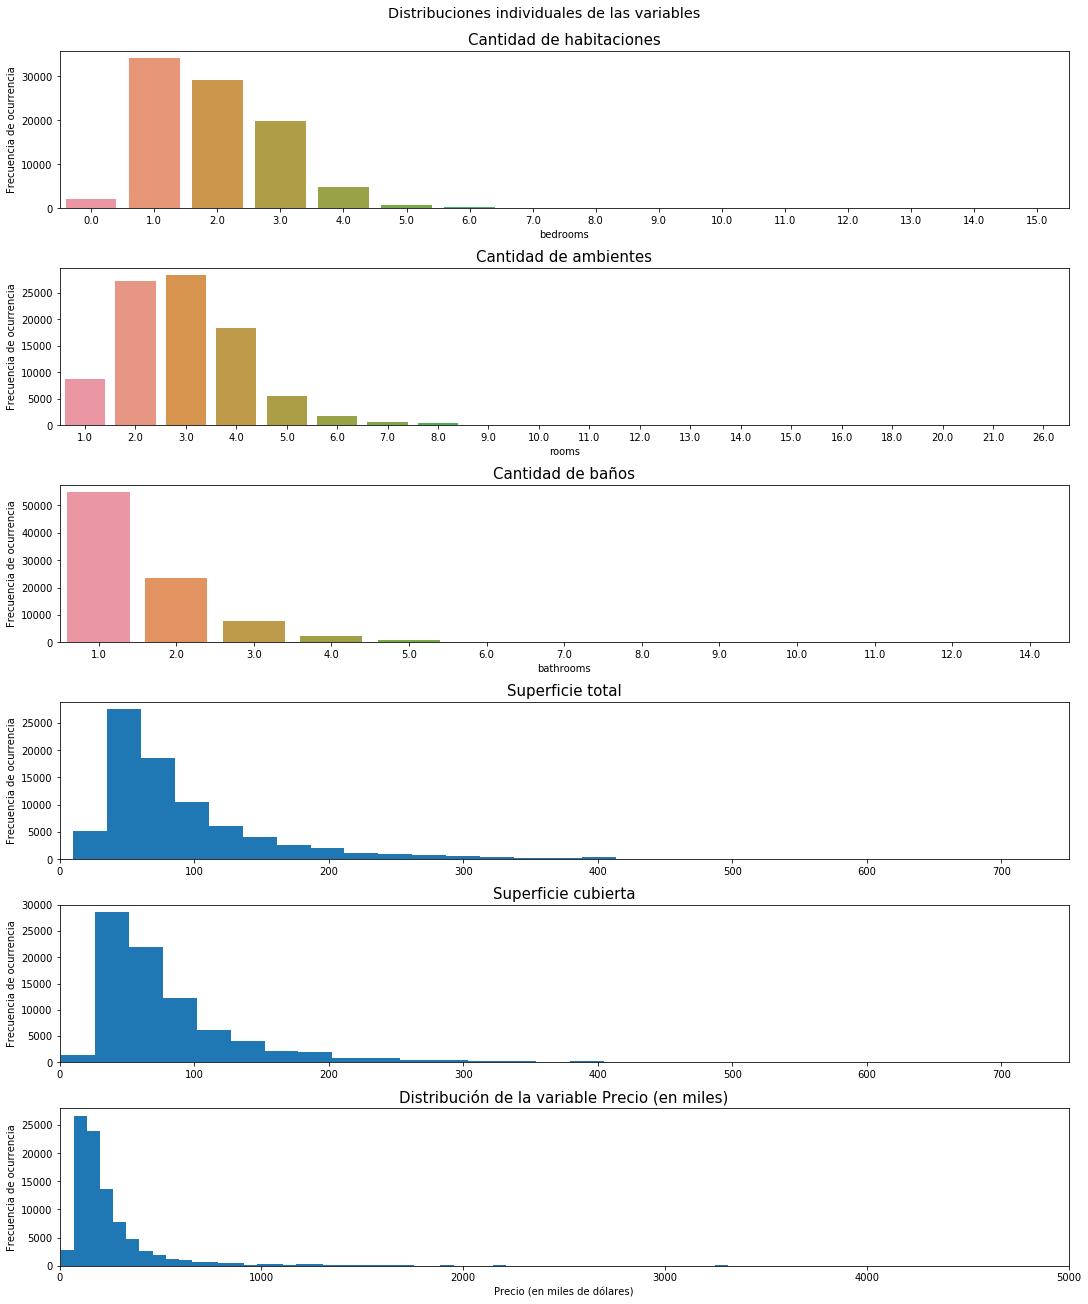

In [9]:
fig, axes = plt.subplots(6, 1, figsize=(15,18), constrained_layout=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

sns.countplot(properatidf["bedrooms"],
              ax=ax1)
ax1.set_ylabel('Frecuencia de ocurrencia')
ax1.set_title("Cantidad de habitaciones", fontdict={"fontsize":15})

sns.countplot(properatidf["rooms"],
              ax=ax2)
ax2.set_ylabel('Frecuencia de ocurrencia')
ax2.set_title("Cantidad de ambientes", fontdict={"fontsize":15})

sns.countplot(properatidf["bathrooms"],
              ax=ax3)
ax3.set_ylabel('Frecuencia de ocurrencia')
ax3.set_title("Cantidad de baños", fontdict={"fontsize":15})

ax4.hist(properatidf["surface_total"],
              bins=5000)
ax4.set_xlim(0,750)
ax4.set_ylabel('Frecuencia de ocurrencia')
ax4.set_title("Superficie total", fontdict={"fontsize":15})

ax5.hist(properatidf["surface_covered"],
              bins=5000)
ax5.set_xlim(0,750)
ax5.set_ylabel('Frecuencia de ocurrencia')
ax5.set_title("Superficie cubierta", fontdict={"fontsize":15})

ax6.hist(properatidf["price"]/1000, bins=500)
ax6.set_xlim(0,5000)
ax6.set_ylabel('Frecuencia de ocurrencia')
ax6.set_xlabel('Precio (en miles de dólares)')
ax6.set_title("Distribución de la variable Precio (en miles)", fontdict={"fontsize":15})
fig.suptitle("Distribuciones individuales de las variables", size= "x-large")
plt.show()

Renombro las distintas columnas para mayor claridad sobre los atributos que representan en el dataset:

In [10]:
properatidf.columns=['Ambientes','Habitaciones','Baños','Superficie total','Superficie cubierta','Precio','Tipo de propiedad']
properatidf

,Ambientes,Habitaciones,Baños,Superficie total,Superficie cubierta,Precio,Tipo de propiedad
0,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,2.0,1.0,1.0,85.0,50.0,295000.0,PH
5,2.0,1.0,1.0,56.0,56.0,150000.0,PH
...,...,...,...,...,...,...,...
146554,4.0,3.0,3.0,175.0,111.0,570000.0,PH
146555,3.0,2.0,2.0,144.0,134.0,480000.0,PH
146556,4.0,2.0,2.0,317.0,143.0,530000.0,PH
146557,3.0,2.0,2.0,145.0,145.0,420000.0,Departamento


A continuación, grafico las distintas relaciones entre atributos de a pares en un **pairplot**. Se puede observar que debido a que se grafican todos los valores del dataset, los *outliers* no permiten observar la forma de las distintas distribuciones con mayor claridad, por lo que resultaría conveniente limpiarlo de los valores atípicos, que es lo que realizaremos en los próximos pasos

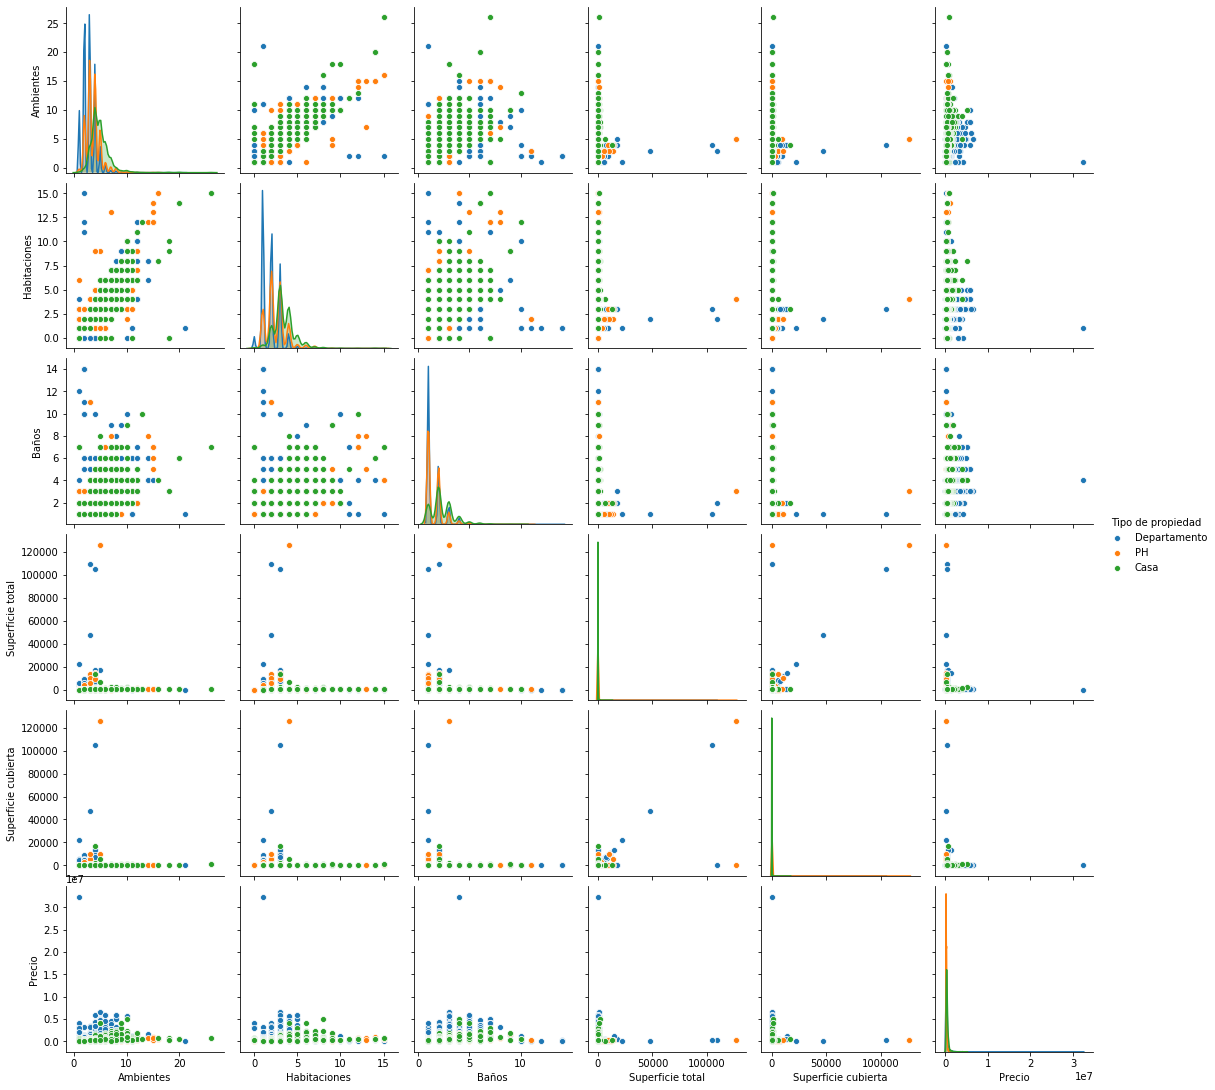

In [11]:
sns.pairplot(data=properatidf,hue='Tipo de propiedad')

Los estadísticos del dataset para las distintas variables son los siguientes

In [12]:
properatidf.describe()

,Ambientes,Habitaciones,Baños,Superficie total,Superficie cubierta,Precio
count,91485.000000,91485.000000,89314.000000,82568.000000,82250.000000,9.148500e+04
mean,2.964278,1.960278,1.560147,112.626369,94.966310,2.595003e+05
std,1.314704,1.072946,0.860309,980.713664,778.515243,3.222654e+05
min,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,2.000000,1.000000,1.000000,49.000000,44.000000,1.200000e+05
50%,3.000000,2.000000,1.000000,71.000000,63.000000,1.750000e+05
75%,4.000000,3.000000,2.000000,111.000000,96.000000,2.790000e+05
max,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


Respecto a los valores atípicos, del mismo puedo obtener las siguientes observaciones:
- Existe al menos una propiedad con 14 baños, lo que resulta a priori excesivo
- Existe una propiedad con 10 m^2, esto puede constituir un error de carga ya que no existen departamentos con esa superficie, lo mismo que la propiedad de 126062 m^2
- Existe al menos una propiedad con 26 habitaciones
- Existe al menos una propiedad con 15 cuartos

--------------

Como se puede observar en el siguiente boxplot, algunos tipos de propiedades presentan grandes desviaciones respecto a la superficie de la mayoría de los casos. Esto podría deberse a errores en la carga de datos

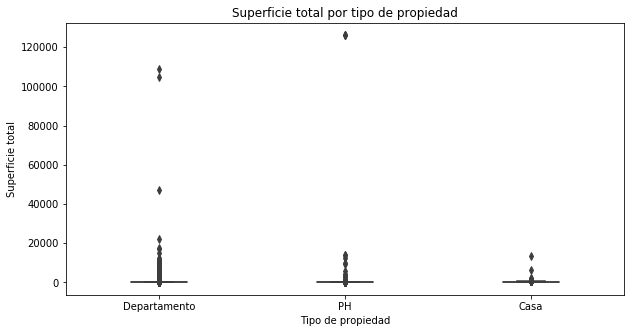

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(data= properatidf,x='Tipo de propiedad',y='Superficie total',width=0.3)
plt.title('Superficie total por tipo de propiedad')
plt.show()

Resulta conveniente, entonces, descartar las propiedades por encima de los 600 m2. A continuación se puede observar el resultado

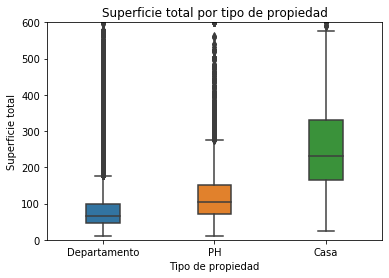

In [14]:
sns.boxplot(data=properatidf,x='Tipo de propiedad',y='Superficie total',width=0.3)
plt.xlabel('Tipo de propiedad')
plt.ylabel('Superficie total')
plt.title('Superficie total por tipo de propiedad')
plt.ylim(0,600)
plt.show()

Al mismo tiempo, acercando el gráfico para los valores bajos, se puede observar que no existen propiedades por debajo de los 9 m2. Así, también ajusto el límite inferior del gráfico a este valor

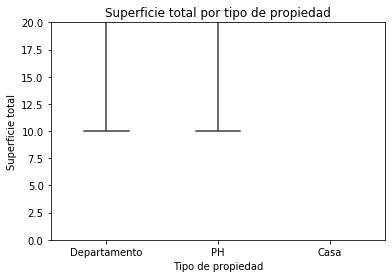

In [15]:
sns.boxplot(data= properatidf,x='Tipo de propiedad',y='Superficie total')
plt.xlabel('Tipo de propiedad')
plt.ylabel('Superficie total')
plt.title('Superficie total por tipo de propiedad')
plt.ylim(0,20)
plt.show()

Los precios también presentan una dispersión significativa. Se presentarán a continuación un **boxplot** para determinar que el rango de precios en USD de las distintas propiedades a considerar será de **[6.000 - 850.000]**

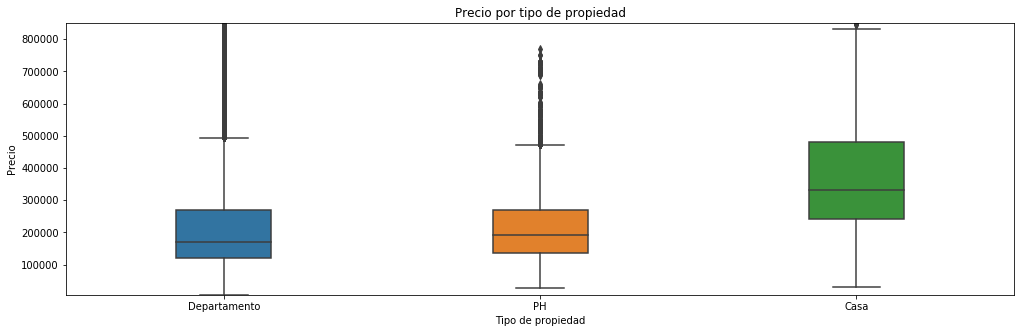

In [16]:
plt.figure(figsize=(17,5))
sns.boxplot(data=properatidf,x='Tipo de propiedad',y='Precio',width=0.3)
plt.ylim(6000,850000)
plt.title('Precio por tipo de propiedad')
plt.xlabel('Tipo de propiedad')
plt.ylabel('Precio')
plt.show()

Aplico el filtrado anterior al dataframe con el que estoy trabajando

In [17]:
nuevoFiltrado = properatidf[(properatidf['Superficie total'] >= 9) & (properatidf['Superficie total'] <= 600) & (properatidf['Precio'] >= 6000)& (properatidf['Precio'] <= 850000)]

También elimino las instancias en las cuales la superficie total es mayor a la cubierta, ya que corresponden a errores de carga

In [18]:
nuevoFiltrado = nuevoFiltrado[(nuevoFiltrado['Superficie total'] >nuevoFiltrado['Superficie cubierta'])]

Muestro las relaciones de a pares en el siguiente **pairplot**. Se puede observar que el filtrado cambió la forma de las distribuciones respecto al anterior y permite un mejor análisis

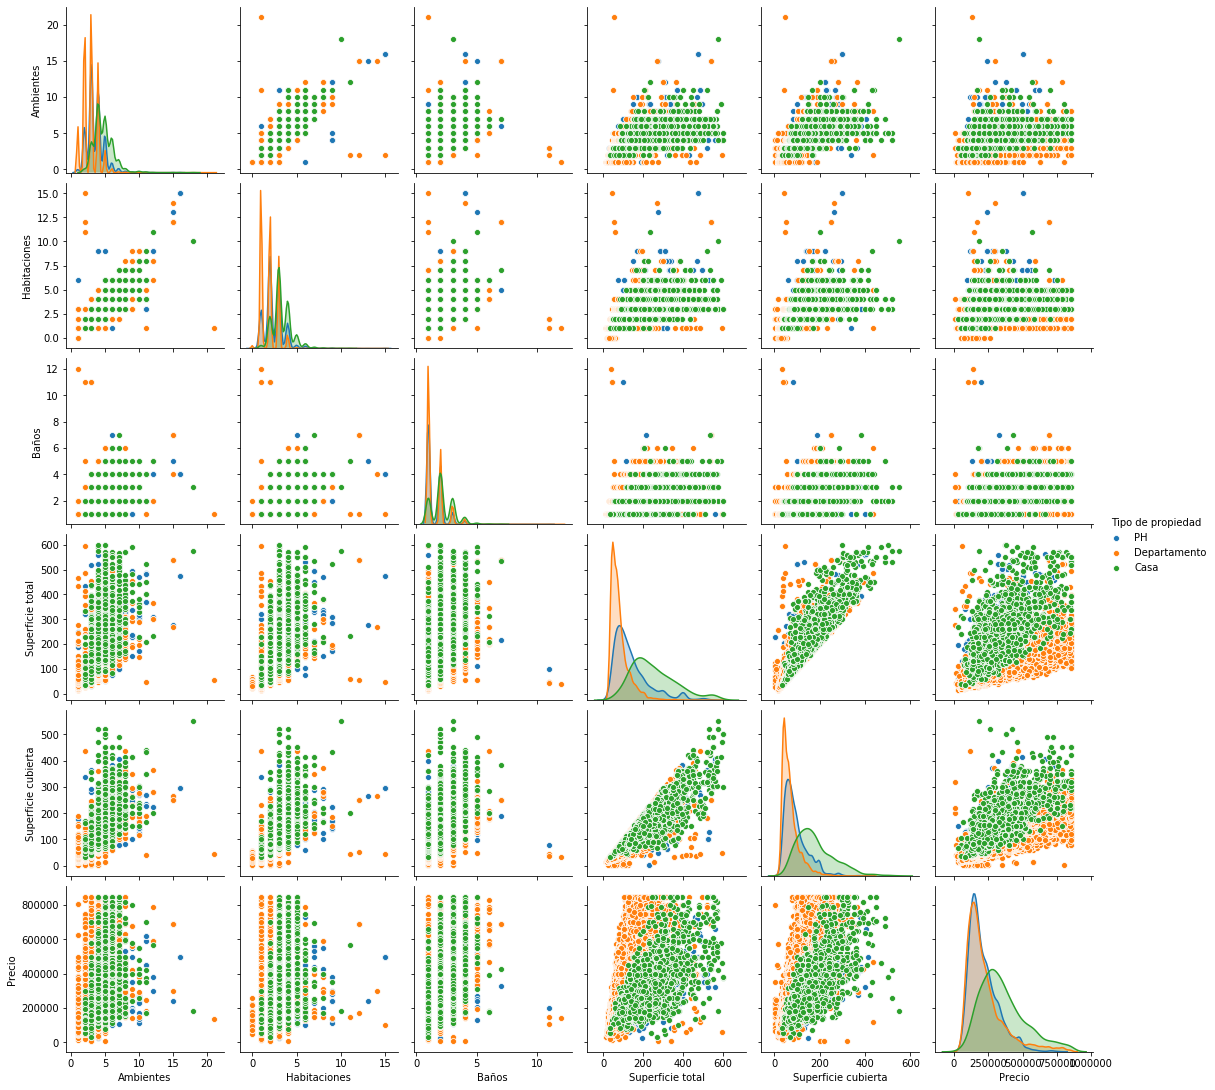

In [19]:
sns.pairplot(data=nuevoFiltrado,hue='Tipo de propiedad')

A continuación, genero un mapa de calor para ver de forma más sencilla la correlación entre las distintas variables

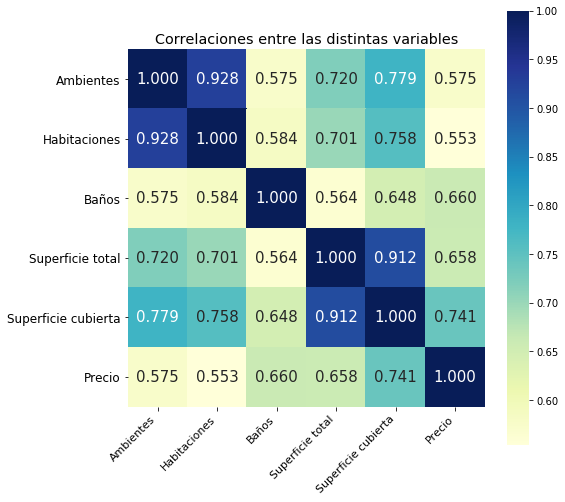

In [20]:
data = nuevoFiltrado
corr = data.corr(method="pearson")
plt.figure(figsize=(8,8))
ax = sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.3f',annot_kws={'size': 15},
            cmap= 'YlGnBu')
ax.set_title("Correlaciones entre las distintas variables", fontsize='x-large')
ax.set_xticklabels(data.columns,rotation = 45, fontsize = 12,horizontalalignment= 'right')
ax.set_yticklabels(data.columns,rotation = 0, fontsize = 12)
plt.xticks(rotation= 45, fontsize= 11, horizontalalignment= 'right')
plt.show()

Se puede observar lo siguiente:
- La cantidad de habitaciones y ambientes correlaciona en gran medida.
- No existe una gran diferencia entre la cantidad de m2 destinados a superficies cubiertas y totales. Esto se explica en el hecho que la gran mayoría de las publicaciones corresponden a  departamentos cuya superficie no cubierta es prácticamente idéntica a la cubierta
- Las 3 mejores variables predictoras para el precio (ya que las mismas correlacionan mejor con este atributo) son, en orden: **Superficie cubierta**, **baños** y **Superficie total** 

--------------

Como pregunta adicional, me propongo observar de qué forma correlaciona la cantidad de m^2 promedio de los departamentos de cada barrio con la densidad de población de cada uno.

Parto de la hipótesis de que a mayor precio de propiedades por m2 menor va a ser la densidad poblacional, ya que los precios altos limitan la cantidad de personas que pueden vivir en el mismo por poder adquisitivo. Es de esperar que a mayor precio, menor sea la cantidad de personas que puedan acceder a alquilar una vivienda en dicho barrio

Para esto, en primer lugar tomo el dataset público del Gobierno de la Ciudad de Buenos Aires

In [50]:
# Cargo dataset
datasetCiudad = pd.read_excel('https://www.estadisticaciudad.gob.ar/eyc/wp-content/uploads/2010/01/PB2_22n.xls',header=1)
# Elimino filas no relevantes
datasetCiudad.drop([0,1,65,66],axis = 0,inplace=True)
datasetCiudad = datasetCiudad[~datasetCiudad['Comuna y Barrio'].str.contains('Comuna',na=False)]

# Selecciono la columna de interés
densidades = datasetCiudad.iloc[:,[0,-1]]
densidades

,Comuna y Barrio,Densidad poblacional (hab/km2)
3,Constitución,20973.408593
4,Monserrat,18159.136759
5,Puerto Madero,1338.398260
6,Retiro,14450.244268
7,San Nicolás,12784.946328
8,San Telmo,16601.427106
10,Recoleta,25100.487842
12,Balvanera,31991.007052
13,San Cristobal,23785.651084
15,Barracas,11240.806796


Chequeo la lista de valores únicos del dataset de Properati

In [23]:
list(properati['l3'].unique())

['San Cristobal',
 'Boedo',
 'Palermo',
 'La Plata',
 'Villa Crespo',
 'Parque Patricios',
 'Villa Pueyrredón',
 'Pilar',
 'Tigre',
 'Abasto',
 'Flores',
 'Morón',
 'Nuñez',
 'Almagro',
 'Belgrano',
 'Floresta',
 'Recoleta',
 'Balvanera',
 'Caballito',
 'Chacarita',
 'San Telmo',
 'Colegiales',
 'La Matanza',
 'San Isidro',
 'San Miguel',
 'Villa Luro',
 'Barrio Norte',
 'Las Cañitas',
 'San Nicolás',
 'Villa Urquiza',
 'Vicente López',
 'Parque Centenario',
 'General San Martín',
 'Villa General Mitre',
 'Lanús',
 'Ituzaingó',
 'Boca',
 'Once',
 'Retiro',
 'Monserrat',
 'Avellaneda',
 'San Fernando',
 'Puerto Madero',
 'Villa Ortuzar',
 'Parque Chacabuco',
 'Centro / Microcentro',
 'Tres de Febrero',
 'Liniers',
 'Coghlan',
 'Congreso',
 'Paternal',
 'Saavedra',
 'Villa Santa Rita',
 'Barracas',
 'Villa Lugano',
 'Constitución',
 'Mataderos',
 'Villa Devoto',
 'Parque Avellaneda',
 'Villa del Parque',
 'Esteban Echeverría',
 'Lomas de Zamora',
 'Almirante Brown',
 'Ezeiza',
 'San Vice

Chequeo los barrios no presentes en la lista publicada por el gobierno de la ciudad

In [24]:
buenosAires = properati.loc[properati['l2'] == 'Capital Federal']
list(buenosAires['l3'].unique()[~np.in1d(buenosAires['l3'].unique(),densidades['Comuna y Barrio'])])

['Abasto',
 'Barrio Norte',
 'Las Cañitas',
 'Parque Centenario',
 'Villa General Mitre',
 'Once',
 'Centro / Microcentro',
 'Congreso',
 'Villa Santa Rita',
 'Villa Lugano',
 'Villa del Parque',
 'Pompeya',
 'Tribunales',
 'Catalinas']

Se puede observar que los barrios presentes en el dataset de Properati que no se encuentran en el dataset del GCBA se deben a que en muchos casos son subdivisiones no oficiales (por ejemplo, Once y Abasto se encuentran contenidos oficialmente en el barrio de Balvanera, lo mismo que Catalinas dentro de La Boca).

En otros, se debe a una diferencia en la denominación. Estos son:
- Nueva Pompeya = Pompeya
- Santa Rita = Villa Santa Rita
- Villa del Parque = Villa del Parque
- Villa Gral Mitre = Villa General Mitre
- Lugano = Villa Lugano

Renombro los barrios con nombres similares

In [25]:
densidades['Comuna y Barrio'][17] = 'Pompeya'
densidades['Comuna y Barrio'][28] = 'Villa Santa Rita'
densidades['Comuna y Barrio'][43] = 'Villa del Parque'
densidades['Comuna y Barrio'][44] = 'Villa General Mitre'
densidades['Comuna y Barrio'][46] = 'Villa Lugano'
densidades

C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

,Comuna y Barrio,Densidad poblacional (hab/km2)
3,Constitución,20973.408593
4,Monserrat,18159.136759
5,Puerto Madero,1338.398260
6,Retiro,14450.244268
7,San Nicolás,12784.946328
8,San Telmo,16601.427106
10,Recoleta,25100.487842
12,Balvanera,31991.007052
13,San Cristobal,23785.651084
15,Barracas,11240.806796


Calculo el precio promedio y superficie de todas las propiedades

In [26]:
# Calculo los promedio de todas las variables del dataframe buenosAires
preciosPromedio = buenosAires.groupby("l3").mean()

# Divido los precios por la superficie promedio
m2Promedio = preciosPromedio['price']/preciosPromedio['surface_total']

# Transformo m2Promedio de serie a dataframe para poder fusionarlo con el dataframe densidades
m2Promedio = m2Promedio.to_frame().reset_index()

# Renombro las columnas
m2Promedio.columns = ['Comuna y Barrio','Precio promedio por m2']
m2Promedio

,Comuna y Barrio,Precio promedio por m2
0,Abasto,2253.277927
1,Agronomía,1862.569895
2,Almagro,2002.916725
3,Balvanera,1610.715356
4,Barracas,2028.458230
5,Barrio Norte,2161.002141
6,Belgrano,2948.613007
7,Boca,943.365470
8,Boedo,1641.892235
9,Caballito,1331.503492


Fusiono los 2 datasets y los ordeno por densidad poblacional

In [27]:
desafio = pd.merge(densidades,m2Promedio,on='Comuna y Barrio',how='left')
desafio = desafio.sort_values(by=['Densidad poblacional (hab/km2)'])
desafio

,Comuna y Barrio,Densidad poblacional (hab/km2),Precio promedio por m2
2,Puerto Madero,1338.398260,6188.826732
19,Villa Riachuelo,3297.353267,3946.296920
20,Villa Soldati,5356.741201,712.543858
42,Agronomía,6555.332042,1862.569895
11,Pompeya,8588.160545,689.006675
22,Mataderos,8713.768363,1274.081622
45,Paternal,8843.156343,1498.295011
43,Chacarita,8902.578237,1997.542582
10,Boca,8981.300835,943.365470
35,Saavedra,9088.610441,2169.991499


Grafico los datos

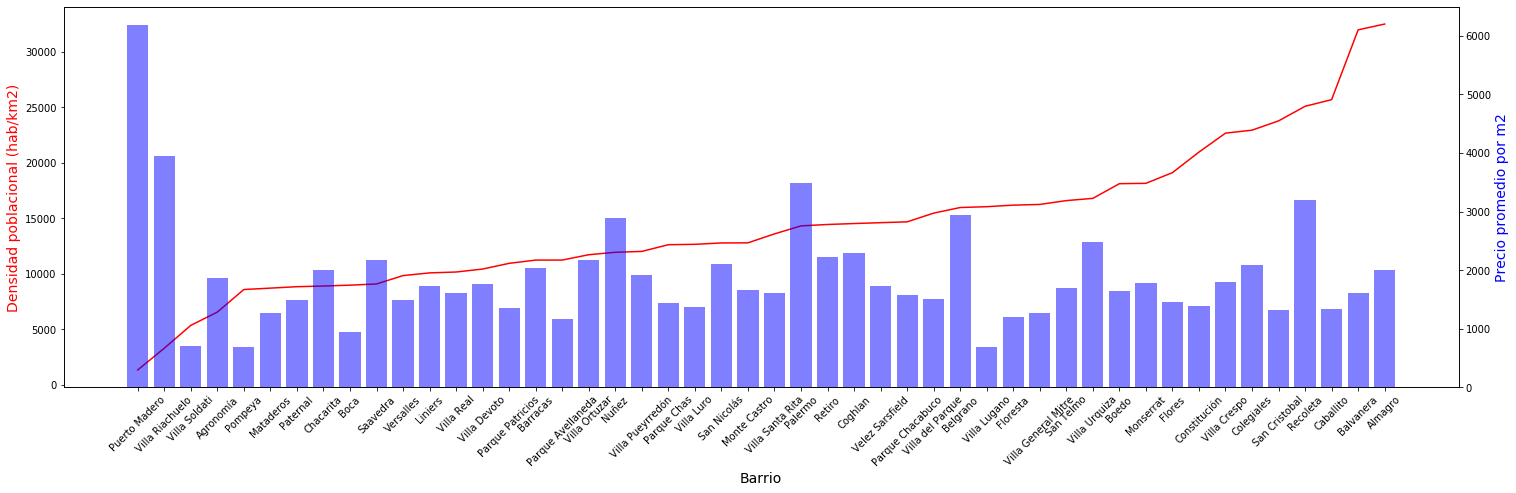

In [28]:
fig, ax = plt.subplots(figsize=(25,7))

# Grafico la densidad poblacional con una línea
ax.plot(desafio['Comuna y Barrio'],desafio['Densidad poblacional (hab/km2)'], color="red")
ax.set_xlabel("Barrio",fontsize=14)
plt.xticks(rotation=45)
# Etiqueta del eje Y principal
ax.set_ylabel("Densidad poblacional (hab/km2)",color="red",fontsize=14)


ax2=ax.twinx()
# Grafico el precio por m2 con barras
ax2.bar(desafio['Comuna y Barrio'],desafio['Precio promedio por m2'],color="blue",alpha=0.5)
# Etiqueta del eje Y secundario
ax2.set_ylabel("Precio promedio por m2",color="blue",fontsize=14)

plt.show()

Y por último analizo la correlación en valores numéricos

In [29]:
desafio.corr()

,Densidad poblacional (hab/km2),Precio promedio por m2
Densidad poblacional (hab/km2),1.000000,-0.193164
Precio promedio por m2,-0.193164,1.000000


**Conclusión**: se puede observar que si bien es cierto que la tendencia es inversa (a mayor precio del m2, menor densidad poblacional), la correlación no es muy fuerte.

# 3. Machine Learning

## Alcance

En la presente sección se entrenarán 2 modelos de machine learning para poder predecir los precios de las propiedades presentes en el dataset, se los comparará con un modelo benchmark, se optimizarán sus hiperparámetros para poder reducir el error y finalmente se realizará un análisis sobre la metodología propuesta

## Desarrollo

Importo las librerías necesarias para esta sección:

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

Teniendo en cuenta lo obtenido en el apartado 1 ("Análisis exploratorio de datos"), para la presente sección seleccionaré los siguientes datos:
- Propiedades en Capital Federal, tipo Departamento, PH o Casa, cuya superficie total sea menor a 1000 m2 y mayor a 15 m2, cuyo precio es menor 4000000 dólares.
- Sólo utilizo las columnas 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered' y 'price'.
- Descarto aquellas instacias con valores faltantes.

In [31]:
# Filtro propiedades de tipo PH, departamento o casa ubicadas en Capital Federal 
filtrado = properati[properati.property_type.isin(['PH','Departamento','Casa'])& properati.l2.isin(['Capital Federal'])]

# Filtro propiedades de superficie total superior a 15 e inferior a 1000
filtrado = filtrado[(filtrado['surface_total'] >= 15) & (filtrado['surface_total'] <= 1000)]

# Filtro propiedades de precio inferior a $4.000.000
filtrado = filtrado[(filtrado['price'] <= 4000000)]

# Separo los atributos que no sean cantidad de ambientes, habitaciones, baños, superficie total, superficie cubierta y precio
filtrado = filtrado.drop(columns=['lat','lon','start_date','end_date','created_on','l1','l2','l3','currency','title','description','operation_type','property_type'])

# Descarto las instancias con valores faltantes
filtrado = filtrado.dropna(axis=0)
filtrado.shape

(81019, 6)

Para la evaluación de la regresión, se utilizará el indicador **RMSE**, el cual se define a continuación

![title](https://miro.medium.com/max/966/1*lqDsPkfXPGen32Uem1PTNg.png)

Esto es porque, por un lado, el **MSE** presenta una sensibilidad demasiado alta a valores atípicos, y, por otro, el **MAE** los penaliza muy poco

Selecciono las variables predictoras (**X**) y la variable a predecir (**y**)

In [32]:
X = filtrado.drop(columns= ['price'])
y = filtrado['price']

Realizo un train/test/split 70/30%

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 5)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(56713, 5) (56713,) (24306, 5) (24306,)


Genero un modelo benchmark para comparar los rendimientos de las distintas regresiones, en este caso consistirá en una **regresión lineal**. Lo entreno y realizo la predicción

In [34]:
# Selecciono el modelo de regresión
linear_model = LinearRegression()

# Entreno el modelo
linear_model.fit(X_train, y_train)

# Realizo predicciones para el set de entrenamiento y evaluación
y_train_pred_linear = linear_model.predict(X_train)
y_test_pred_linear = linear_model.predict(X_test)

# Calculo el RMSE para ambos sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_linear))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_linear))

# Imprimo el resultado
print("El RMSE del benchmark en train es:",rmse_train)
print("El RMSE del benchmark en test es:",rmse_test)

El RMSE del benchmark en train es: 201083.63734027682
El RMSE del benchmark en test es: 197812.84011839097


Realizo una regresión mediante árboles de decisión. Se puede observar que el error es menor que el del modelo benchmark

In [35]:
# Selecciono el modelo de regresión y sus parámetros
tree_regressor = DecisionTreeRegressor(random_state=30)

# Entreno el modelo
tree_regressor.fit(X_train, y_train)

# Realizo predicciones para el set de entrenamiento y evaluación
y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)

# Calculo el RMSE para ambos sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Imprimo el resultado
print("El RMSE del modelo de árbol de decisión en train es:",rmse_train)
print("El RMSE del modelo de árbol de decisión en test es:",rmse_test)

El RMSE del modelo de árbol de decisión en train es: 54659.18987126869
El RMSE del modelo de árbol de decisión en test es: 139057.86697472306


Realizo lo mismo para el modelo KNN, el cual presenta un error mayor al anterior

In [36]:
# Selecciono el modelo de regresión y sus parámetros
KNN_regressor = KNeighborsRegressor()

# Entreno el modelo
KNN_regressor.fit(X_train, y_train)

# Realizo predicciones para el set de entrenamiento y evaluación
y_train_pred = KNN_regressor.predict(X_train)
y_test_pred = KNN_regressor.predict(X_test)


# Calculo el RMSE para ambos sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Imprimo el resultado
print("El RMSE del modelo KNN en train es:",rmse_train)
print("El RMSE del modelo KNN en test es:",rmse_test)

El RMSE del modelo KNN en train es: 123865.16561014786
El RMSE del modelo KNN en test es: 152607.73446789617


Grafico los valores predichos vs valores reales. Se puede observar que el modelo que mejor predice el set de prueba es el de árboles de decisión, ya que presenta RMSE mucho más bajo que las otras 2 alternativas

Resumen de los modelos con el dataset de la consigna
Modelo: Regresión lineal
Raíz del error cuadrático medio en Train: 201083.637
Raíz del error cuadrático medio en Test: 197812.84


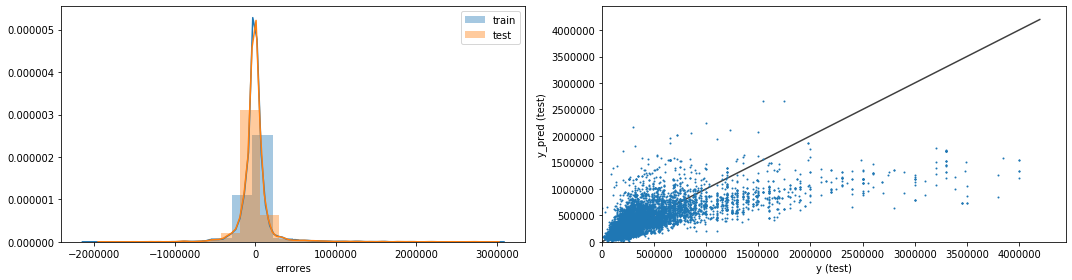

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 54659.19
Raíz del error cuadrático medio en Test: 139057.867


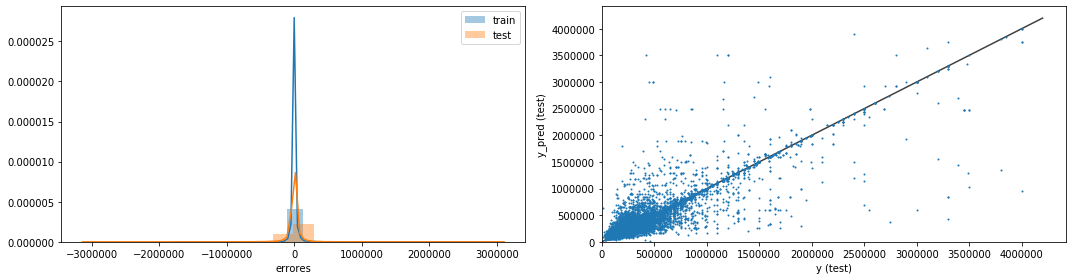

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 123865.166
Raíz del error cuadrático medio en Test: 152607.734


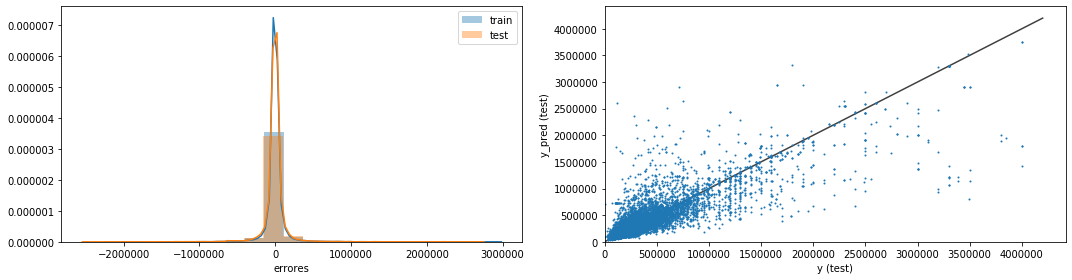

In [37]:
# Selecciono los distintos modelos
modelos = ['Regresión lineal', 'Árbol de Decisión', 'Vecinos más cercanos']

print('Resumen de los modelos con el dataset de la consigna')
for i, model in enumerate([linear_model, tree_regressor, KNN_regressor]):

    # Realizo predicciones para el set de entrenamiento y evaluación
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')

    # Calculo el RMSE para ambos sets
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {round(rmse_train,3)}')
    print(f'Raíz del error cuadrático medio en Test: {round(rmse_test,3)}')
    
    plt.figure(figsize = (15,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s = 1)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min de ambos ejes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max de ambos ejes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlim(0,)
    plt.ylim(0,)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

Grafico el RMSE para los distintos hiperparámetros para obtener el valor óptimo para el modelo de árboles de decisión

RMSE mínimo en test de $138,384.87 , correspondiente a la profundidad k =  22


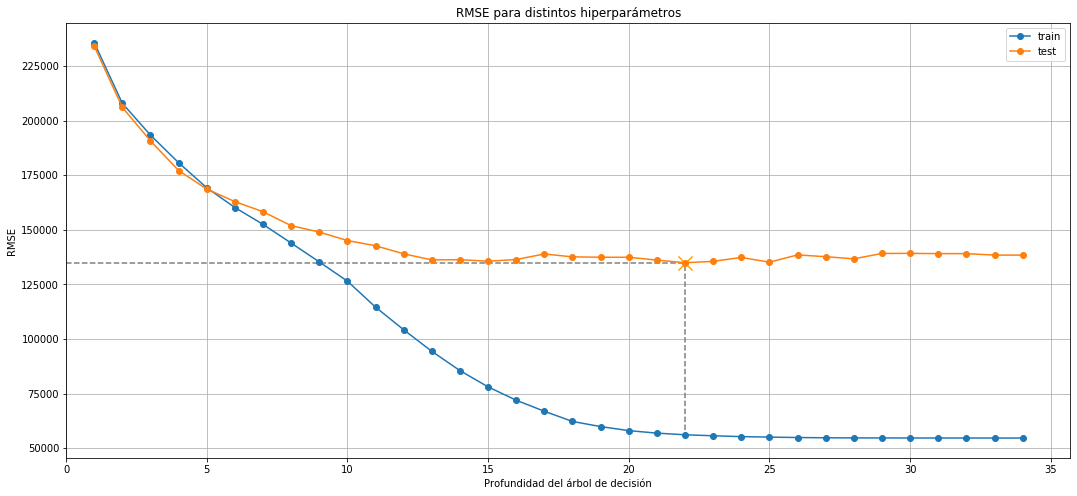

In [38]:
# Defino las listas vacías para los valores de accuracy deseados
rmse_accuracy_train = []
rmse_accuracy_test = []

# Defino la lista de valores de profundidad del árbol
max_depths = np.arange(1,35)

# Genero un loop sobre los distintos valores de profundidad 
for max_depth in max_depths:
    
    # Defino el modelo con el valor de profundidad
    rgrT = DecisionTreeRegressor(max_depth = max_depth, random_state=42)
    
    # Entreno el modelo
    rgrT.fit(X_train,y_train)
    
    # Evalúo sobre el set de entrenamiento
    y_train_pred = rgrT.predict(X_train)
    rmse_accTrain = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Evalúo sobre el set de evaluación
    y_test_pred = rgrT.predict(X_test)
    rmse_accTest = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Agrego la información a las listas
    rmse_accuracy_train.append(rmse_accTrain)
    rmse_accuracy_test.append(rmse_accTest)
    
    rmse_dt_min = min(rmse_accuracy_test)
    dt_min = rmse_accuracy_test.index(min(rmse_accuracy_test))+1

    
    
plt.figure(figsize=(18,8))
plt.plot(max_depths,rmse_accuracy_train,'o-',label='train' )
plt.plot(max_depths,rmse_accuracy_test,'o-',label='test')


plt.hlines(rmse_dt_min, 
           xmin = 0, 
           xmax = dt_min, 
           linestyles = 'dashed',
           colors = 'grey')

plt.vlines(dt_min, 
           ymax = rmse_dt_min, 
           ymin = min(rmse_accuracy_train), 
           linestyles = 'dashed',
           colors = 'grey')

plt.scatter(dt_min,rmse_dt_min, s = 200, color = 'orange', marker = "x",)

plt.xlim(0,)
plt.ylabel('RMSE')
plt.xlabel('Profundidad del árbol de decisión')
plt.legend()
plt.title('RMSE para distintos hiperparámetros')
plt.grid()
print('RMSE mínimo en test de '+"${:,.2f}". format(rmse_accTest.min()),
      ', correspondiente a la profundidad k = ',
     f"{rmse_accuracy_test.index(min(rmse_accuracy_test))+1}")

Grafico el RMSE para los distintos hiperparámetros para obtener el valor óptimo para el modelo de vecinos más cercanos

RMSE mínimo en test de $151,076 , correspondiente a la cantidad de vecinos n =  4


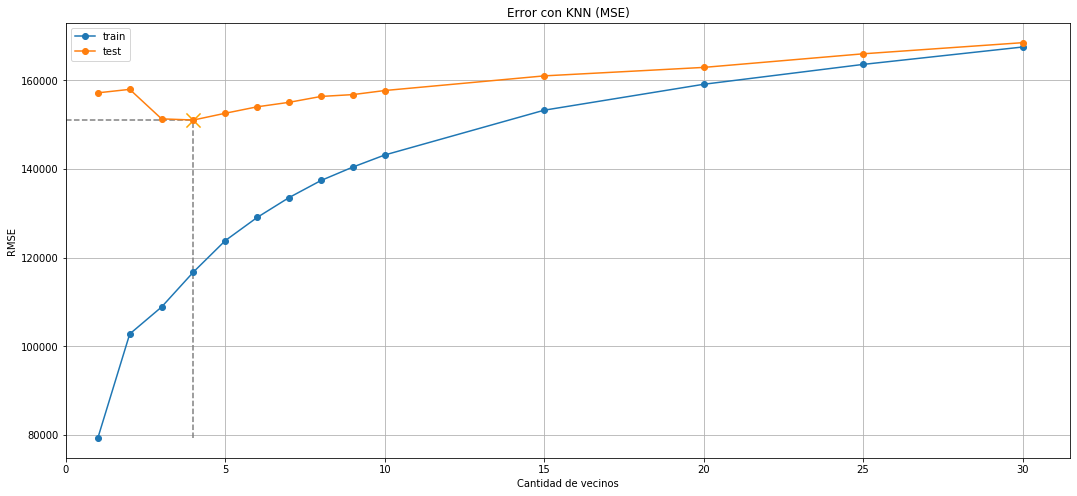

In [39]:
# Defino las listas vacías para los valores de accuracy deseados
rmse_accuracy_train_KNN = []
rmse_accuracy_test_KNN = []

# Defino la lista de valores de k
k_vecinos = [1,2,3,4,5,6,7,8,9,10,15,20,25,30]

# Genero un loop sobre los distintos valores de profundidad 
for k in k_vecinos:
        
    # Defino el modelo con el valor de vecinos a iterar
    KNN = KNeighborsRegressor(n_neighbors=k)
    
    # Entreno el modelo
    KNN.fit(X_train,y_train)
    
    # Evalúo sobre el set de entrenamiento
    y_train_pred = KNN.predict(X_train)
    rmse_accTrain_KNN = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Evalúo sobre el set de evaluación
    y_test_pred = KNN.predict(X_test)
    rmse_accTest_KNN = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Agrego la información a las listas
    rmse_accuracy_train_KNN.append(rmse_accTrain_KNN)
    rmse_accuracy_test_KNN.append(rmse_accTest_KNN)
    
    rmse_KNN_min = min(rmse_accuracy_test_KNN)
    KNN_min = rmse_accuracy_test_KNN.index(min(rmse_accuracy_test_KNN))+1
    
plt.figure(figsize=(18,8))
plt.plot(k_vecinos,rmse_accuracy_train_KNN,'o-',label='train' )
plt.plot(k_vecinos,rmse_accuracy_test_KNN,'o-',label='test')

plt.hlines(rmse_KNN_min, 
           xmin = 0, 
           xmax = KNN_min, 
           linestyles = 'dashed',
           colors = 'grey')

plt.vlines(KNN_min, 
           ymax = rmse_KNN_min, 
           ymin = min(rmse_accuracy_train_KNN), 
           linestyles = 'dashed',
           colors = 'grey')

plt.scatter(KNN_min,rmse_KNN_min, s = 200, color = 'orange', marker = "x")

plt.xlim(0,)
plt.ylabel('RMSE')
plt.xlabel('Cantidad de vecinos')
plt.legend()
plt.title('Error con KNN (MSE)')
plt.grid()

print('RMSE mínimo en test de '+"${:,.0f}". format(rmse_KNN_min),
      ', correspondiente a la cantidad de vecinos n = ',
     f"{KNN_min}")

Se desprende del análisis realizado en la presente sección que el modelo que mejor se adapta al problema planteado es el de árboles de decisión, con un **n = 4**

# Conclusiones

Si bien el análisis realizado hasta el momento permite seleccionar el mejor modelo de regresión por comparación de errores relativos, este no tiene en cuenta la viablidad real de realizar un análisis con la finalidad de realizar predicciones de precios, que es el objetivo del presente documento. Cabe destacar que US$138.384, que es el valor del RMSE, es a la vez el valor de algunos departamentos, por lo que resulta inadmisible un error de esta magnitud.

El presente modelo presenta algunas oportunidades de mejora, como por ejemplo:
- Se podría realizar un mejor tratamiento de valores faltantes, como por ejemplo imputación, en vez de eliminar estas instancias del dataset
- Se podría introducir al análisis las variables categóricas como el barrio o tal vez la presencia de algunas palabras clave dentro de la descripción
- Se podrían utilizar datos externos al dataset como la ubicación de algunos puntos de interés (como estaciones de subte, hospitales, escuelas o paradas de autobús) relativos a las propiedades utilizando las coordenadas
- Como mejora a futuro del dataset y teniendo en cuenta que el pricing de una propiedad (y más en un mercado inmobiliario como el argentino) puede presentar grandes variaciones en un corto período de tiempo, se podría adicionar la variable "concreción de la operación de venta". Esta variable categórica resultaría fácil de recolectar, y a la vez penalizaría los precios excesivamente altos, resultando en una mejora de la capacidad predictiva del modelo.